# Quantum Transpilation Analysis with SupermarQ

## Interactive Tutorial Notebook

Welcome to this interactive tutorial on quantum circuit transpilation analysis! This notebook provides hands-on experience with:

- **Quantum Algorithm Implementation** - Six fundamental quantum algorithms
- **Circuit Transpilation** - Optimizing circuits for real quantum hardware
- **Performance Benchmarking** - Using SupermarQ metrics to evaluate quality
- **Comparative Analysis** - Understanding trade-offs across optimization levels

### Learning Objectives

By the end of this tutorial, you will:
1. Understand how quantum transpilation affects circuit performance
2. Be able to analyze quantum algorithms using SupermarQ metrics
3. Visualize and interpret optimization trade-offs
4. Implement custom quantum benchmarking experiments

### Prerequisites

- Basic understanding of quantum computing concepts (qubits, gates, superposition)
- Familiarity with Python programming
- Qiskit and SupermarQ installed (see setup section below)

---

## Section 1: Environment Setup and Verification

Let's start by importing required libraries and verifying the installation.

**Important**: Run the cell below first to import all necessary packages!

In [130]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Qiskit imports
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import (
    GroverOperator,
    HamiltonianGate,
    EfficientSU2,
    PhaseEstimation,
    QFT,
)
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram, plot_gate_map

# Check versions
import qiskit
print(f"✓ Qiskit version: {qiskit.__version__}")

try:
    import supermarq
    print(f"✓ SupermarQ version: {supermarq.__version__}")
except:
    print("⚠ SupermarQ version check not available")

print("\n✅ All imports successful!")

✓ Qiskit version: 2.1.0
✓ SupermarQ version: 0.5.52

✅ All imports successful!


In [131]:
from qiskit_ibm_runtime.fake_provider import FakeJakartaV2

# FakeJakartaV2 is a 7-qubit backend with realistic noise characteristics
# Compatible with Qiskit 2.0+
# Uses updated backend location for Qiskit 2.x

### Backend Configuration

We'll use Qiskit's `FakeJakartaV2` backend, which simulates a 7-qubit IBM quantum device with:
- **Linear connectivity** - Qubits arranged with specific coupling map
- **Realistic noise model** - Based on real IBM Quantum hardware characteristics
- **Gate timing** - Simulates actual gate execution times

This backend helps us understand how circuits will perform on real quantum hardware.

**Note**: Updated from `Fake7QPulseV1` (paper) to `FakeJakartaV2` for Qiskit 2.0+ compatibility.

Backend: fake_jakarta
Number of qubits: 7

Coupling map (qubit connectivity):
[[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 5], [4, 5], [5, 3], [5, 4], [5, 6], [6, 5]]

Backend Qubit Topology Visualization:


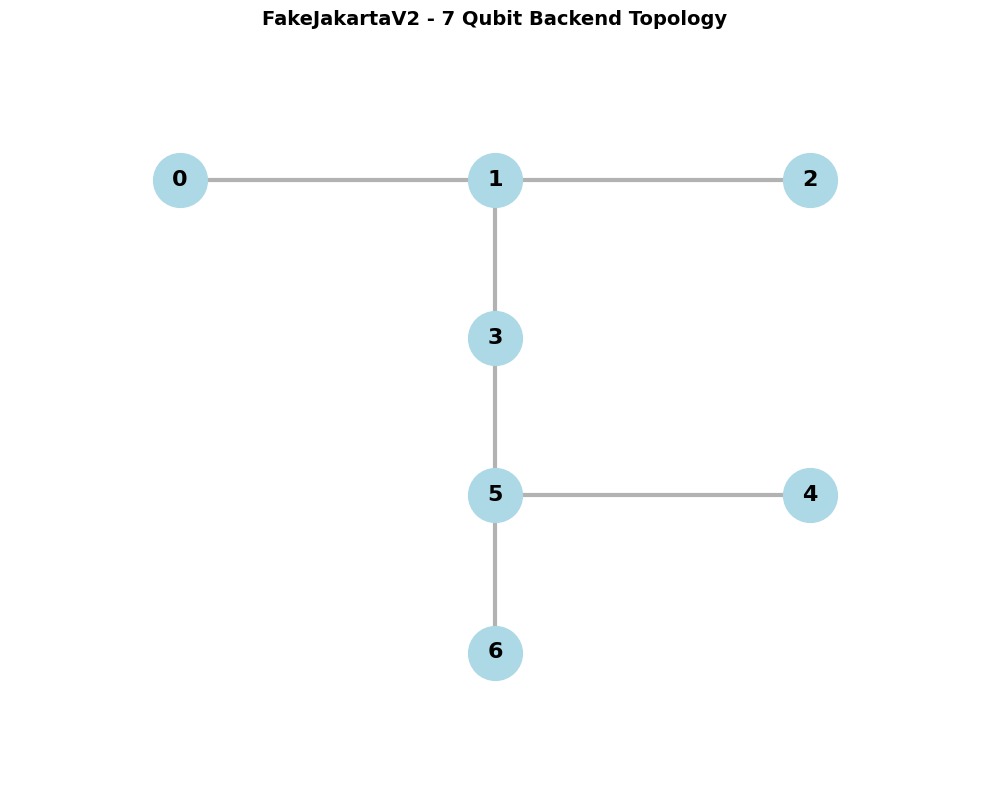


✓ Topology visualization displayed above
✓ Total edges (connections): 6
✓ Connectivity: [(0, 1), (1, 2), (4, 5), (5, 6), (1, 3), (3, 5)]


In [132]:
# Initialize the backend
backend = FakeJakartaV2()
print(f"Backend: {backend.name}")
print(f"Number of qubits: {backend.num_qubits}")
print(f"\nCoupling map (qubit connectivity):")
print(backend.coupling_map)

# Visualize the backend topology
print("\n" + "="*60)
print("Backend Qubit Topology Visualization:")
print("="*60)

# Create a custom network graph visualization
import matplotlib.pyplot as plt
import networkx as nx

# Build graph from coupling map
G = nx.Graph()
G.add_nodes_from(range(backend.num_qubits))

# Add edges (remove duplicates)
edges_added = set()
for edge in backend.coupling_map:
    edge_tuple = tuple(sorted(edge))
    if edge_tuple not in edges_added:
        G.add_edge(edge[0], edge[1])
        edges_added.add(edge_tuple)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Define positions for FakeJakartaV2 topology
pos = {
    0: (0, 2),
    1: (1, 2),
    2: (2, 2),
    3: (1, 1),
    5: (1, 0),
    4: (2, 0),
    6: (1, -1)
}

# Draw the graph
nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                       node_size=1500, ax=ax)
nx.draw_networkx_labels(G, pos, font_size=16, 
                        font_weight='bold', ax=ax)
nx.draw_networkx_edges(G, pos, width=3, alpha=0.6, 
                       edge_color='gray', ax=ax)

ax.set_title("FakeJakartaV2 - 7 Qubit Backend Topology", 
             fontsize=14, fontweight='bold', pad=20)
ax.axis('off')
ax.margins(0.2)

plt.tight_layout()
plt.show()

print("\n✓ Topology visualization displayed above")
print(f"✓ Total edges (connections): {len(edges_added)}")
print(f"✓ Connectivity: {list(edges_added)}")

---
## Section 2: Understanding Quantum Transpilation

### What is Transpilation?

**Transpilation** is the process of converting an abstract quantum circuit into one that can run on specific quantum hardware. This involves:

1. **Basis Gate Translation** - Converting gates to the native gate set
2. **Qubit Mapping** - Assigning logical qubits to physical qubits
3. **SWAP Insertion** - Adding SWAP gates for qubit connectivity
4. **Circuit Optimization** - Reducing gate count and depth

### Optimization Levels

Qiskit provides four optimization levels:

- **Level 0**: Minimal optimization - basic translation only
- **Level 1**: Light optimization - basic gate commutation and cancellation
- **Level 2**: Medium optimization - more aggressive gate optimization
- **Level 3**: Heavy optimization - extensive circuit optimization

Let's see this in action with a simple example:

In [133]:
# Create a simple 3-qubit circuit
demo_circuit = QuantumCircuit(3)
demo_circuit.h(0)
demo_circuit.cx(0, 1)
demo_circuit.cx(1, 2)
demo_circuit.h(2)
demo_circuit.measure_all()

print("Original Circuit:")
print(demo_circuit)
print(f"Depth: {demo_circuit.depth()}, Gates: {demo_circuit.size()}")

# Transpile at different levels
print("\n" + "="*50)
for level in range(4):
    transpiled = transpile(demo_circuit, backend=backend, optimization_level=level)
    print(f"\nLevel {level} - Depth: {transpiled.depth()}, "
          f"Gates: {transpiled.size()}, "
          f"CX count: {transpiled.count_ops().get('cx', 0)}")

Original Circuit:
        ┌───┐                ░ ┌─┐      
   q_0: ┤ H ├──■─────────────░─┤M├──────
        └───┘┌─┴─┐           ░ └╥┘┌─┐   
   q_1: ─────┤ X ├──■────────░──╫─┤M├───
             └───┘┌─┴─┐┌───┐ ░  ║ └╥┘┌─┐
   q_2: ──────────┤ X ├┤ H ├─░──╫──╫─┤M├
                  └───┘└───┘ ░  ║  ║ └╥┘
meas: 3/════════════════════════╩══╩══╩═
                                0  1  2 
Depth: 5, Gates: 7


Level 0 - Depth: 9, Gates: 11, CX count: 2

Level 1 - Depth: 9, Gates: 11, CX count: 2

Level 2 - Depth: 9, Gates: 11, CX count: 2

Level 3 - Depth: 9, Gates: 11, CX count: 2


**Observation**: Notice how higher optimization levels can reduce circuit depth and gate count!

---
## Section 3: Quantum Algorithms - Deep Dive

Now let's implement and analyze six fundamental quantum algorithms.

In [134]:
def create_grover_circuit():
    """Create a 7-qubit Grover's Search circuit."""
    # Oracle: marks state |1111110⟩
    oracle = QuantumCircuit(7)
    oracle.mcx(list(range(6)), 6)
    
    # Create Grover operator
    grover_op = GroverOperator(oracle)
    
    # Build circuit
    circuit = QuantumCircuit(7)
    circuit.h(range(7))  # Superposition
    circuit.compose(grover_op, inplace=True)
    circuit.compose(grover_op, inplace=True)  # 2 iterations
    circuit.measure_all()
    circuit.name = "Grover's Search"
    return circuit

# Create and visualize
grover = create_grover_circuit()
print(f"Grover Circuit - Depth: {grover.depth()}, Qubits: {grover.num_qubits}")
print(f"Gate count: {grover.size()}")

# Draw circuit (decomposed to see structure)
print("\nCircuit diagram (first 5 levels):")
grover.draw('mpl', fold=-1)
plt.show()

Grover Circuit - Depth: 4, Qubits: 7
Gate count: 16

Circuit diagram (first 5 levels):


/var/folders/wy/cxnvm2c15wnd1gp8jd_m7znh0000gn/T/ipykernel_45577/3878177023.py:8: DeprecationWarning: The class ``qiskit.circuit.library.grover_operator.GroverOperator`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use qiskit.circuit.library.grover_operator instead.
  grover_op = GroverOperator(oracle)


In [135]:
def create_amplitude_estimation_circuit():
    """Create a 7-qubit Amplitude Estimation circuit.
    
    Demonstrates amplitude amplification concepts using all 7 qubits
    with entangling operations.
    """
    n = 7
    circuit = QuantumCircuit(n, n)  # Exactly 7 qubits
    
    # State preparation
    circuit.h(range(n))
    
    # Oracle with entangling operations
    circuit.cx(0, 1)
    circuit.cx(1, 2)
    circuit.cx(2, 3)
    
    # Multi-controlled Z gate (phase oracle)
    circuit.h(3)
    circuit.ccx(0, 1, 4)
    circuit.ccx(2, 4, 3)
    circuit.ccx(0, 1, 4)
    circuit.h(3)
    
    # Diffusion operator (amplitude amplification)
    circuit.h(range(4))
    circuit.x(range(4))
    circuit.h(3)
    circuit.ccx(0, 1, 4)
    circuit.ccx(2, 4, 3)
    circuit.ccx(0, 1, 4)
    circuit.h(3)
    circuit.x(range(4))
    circuit.h(range(4))
    
    # Additional entangling layer
    for i in range(n-1):
        circuit.cx(i, i+1)
    
    circuit.measure_all()
    circuit.name = "Amplitude Est"
    return circuit

amplitude = create_amplitude_estimation_circuit()
print(f"Amplitude Estimation - Depth: {amplitude.depth()}, Qubits: {amplitude.num_qubits}")

Amplitude Estimation - Depth: 21, Qubits: 7


In [136]:
def create_hamiltonian_sim_circuit():
    """Create a 7-qubit Hamiltonian Simulation circuit."""
    # Hamiltonian: Z ⊗ I ⊗ I^⊗5
    pauli_z = np.array([[1, 0], [0, -1]])
    identity = np.eye(2)
    identity_32 = np.eye(2**5)
    
    hamiltonian = Operator(np.kron(np.kron(pauli_z, identity), identity_32))
    
    time = 1.0
    circuit = QuantumCircuit(7)
    circuit.append(HamiltonianGate(hamiltonian, time), range(7))
    circuit.measure_all()
    circuit.name = "Hamiltonian Sim"
    return circuit

hamiltonian = create_hamiltonian_sim_circuit()
print(f"Hamiltonian Simulation - Depth: {hamiltonian.depth()}")

Hamiltonian Simulation - Depth: 2


### 🎯 Exercise 1: Create Your Own Algorithm

Try modifying the Grover circuit to search for a different target state!

In [137]:
# Exercise: Modify the oracle to mark a different state
def create_custom_grover(target_qubits):
    """
    Create a custom Grover circuit.
    
    Args:
        target_qubits: List of qubit indices to mark
    """
    oracle = QuantumCircuit(7)
    # TODO: Add your oracle implementation here
    # Hint: Use oracle.mcx(control_qubits, target_qubit)
    
    grover_op = GroverOperator(oracle)
    circuit = QuantumCircuit(7)
    circuit.h(range(7))
    circuit.compose(grover_op, inplace=True)
    circuit.measure_all()
    return circuit

# Test your implementation
# custom_circuit = create_custom_grover([0, 1, 2])
# print(f"Custom circuit depth: {custom_circuit.depth()}")

---
## Section 4: Transpilation Analysis - Hands-On

Let's analyze how transpilation affects a single algorithm across all optimization levels.

In [138]:
def analyze_transpilation(circuit, backend, algorithm_name):
    """Analyze transpilation at all optimization levels."""
    print(f"\nAnalyzing: {algorithm_name}")
    print("="*60)
    
    results = {}
    
    for level in range(4):
        # Transpile
        transpiled = transpile(
            circuit,
            backend=backend,
            optimization_level=level,
            seed_transpiler=42
        )
        
        # Extract metrics
        ops = transpiled.count_ops()
        cx_count = ops.get('cx', 0)
        depth = transpiled.depth()
        gate_count = transpiled.size()
        
        results[level] = {
            'depth': depth,
            'gates': gate_count,
            'cx_gates': cx_count
        }
        
        print(f"Level {level}: Depth={depth:3d}, Gates={gate_count:3d}, CX={cx_count:3d}")
    
    return results

# Analyze Grover's algorithm
grover_analysis = analyze_transpilation(grover, backend, "Grover's Search")


Analyzing: Grover's Search
Level 0: Depth=1792, Gates=2528, CX=1340
Level 1: Depth=1510, Gates=2234, CX=1322
Level 2: Depth=1543, Gates=2633, CX=1188
Level 3: Depth=1543, Gates=2633, CX=1188


### Visualize Transpilation Impact

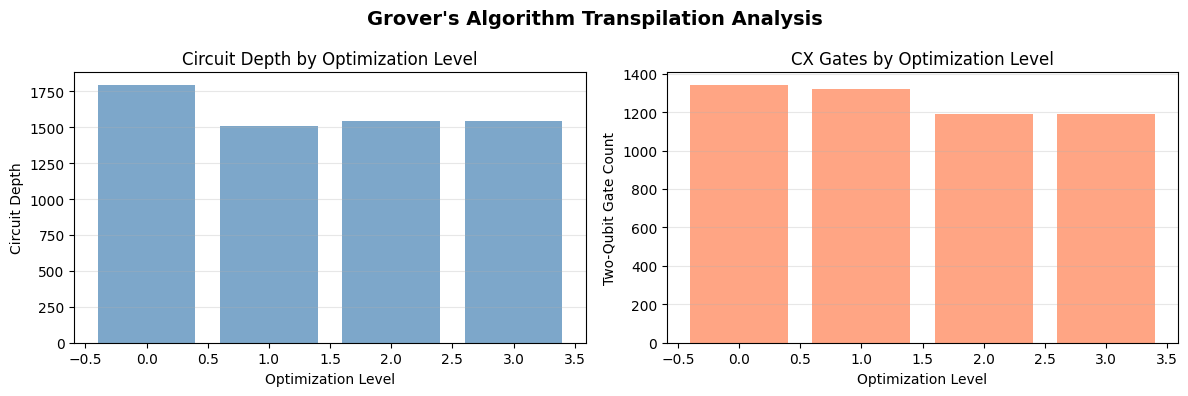

In [139]:
def plot_transpilation_comparison(results, title):
    """Plot transpilation metrics comparison."""
    levels = list(results.keys())
    depths = [results[l]['depth'] for l in levels]
    cx_gates = [results[l]['cx_gates'] for l in levels]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Circuit depth
    ax1.bar(levels, depths, color='steelblue', alpha=0.7)
    ax1.set_xlabel('Optimization Level')
    ax1.set_ylabel('Circuit Depth')
    ax1.set_title('Circuit Depth by Optimization Level')
    ax1.grid(axis='y', alpha=0.3)
    
    # CX gate count
    ax2.bar(levels, cx_gates, color='coral', alpha=0.7)
    ax2.set_xlabel('Optimization Level')
    ax2.set_ylabel('Two-Qubit Gate Count')
    ax2.set_title('CX Gates by Optimization Level')
    ax2.grid(axis='y', alpha=0.3)
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_transpilation_comparison(grover_analysis, "Grover's Algorithm Transpilation Analysis")

---
## Section 5: SupermarQ Benchmarking

### Understanding SupermarQ Metrics

SupermarQ provides five key metrics for circuit quality:

1. **Program Communication (PC)**: Measures inter-qubit interaction requirements
2. **Critical Depth (CD)**: Longest path of dependent operations
3. **Entanglement Ratio (ER)**: Proportion of entangling operations
4. **Liveness (LV)**: Qubit utilization efficiency
5. **Parallelism (PL)**: Potential for concurrent gate execution

In [140]:
def compute_supermarq_metrics(circuit, backend, opt_level):
    """Compute SupermarQ metrics for a circuit."""
    import supermarq.converters as sm_converters
    
    # Transpile first
    transpiled = transpile(
        circuit,
        backend=backend,
        optimization_level=opt_level,
        seed_transpiler=42
    )
    
    # Compute SupermarQ metrics using Qiskit-specific functions (SupermarQ 0.5+)
    pc = sm_converters.compute_communication_with_qiskit(transpiled)
    cd = sm_converters.compute_depth_with_qiskit(transpiled)
    er = sm_converters.compute_entanglement_with_qiskit(transpiled)
    lv = sm_converters.compute_liveness_with_qiskit(transpiled)
    pl = sm_converters.compute_parallelism_with_qiskit(transpiled)
    
    metrics = {
        'PC': pc,   # Program Communication
        'CD': cd,   # Critical Depth
        'ER': er,   # Entanglement Ratio
        'LV': lv,   # Liveness
        'PL': pl    # Parallelism
    }
    
    return metrics

# Compute metrics for Grover at level 2
metrics_l2 = compute_supermarq_metrics(grover, backend, opt_level=2)

print("SupermarQ Metrics (Grover, Optimization Level 2):")
print("="*50)
for name, value in metrics_l2.items():
    print(f"{name}: {value:.4f}")

SupermarQ Metrics (Grover, Optimization Level 2):
PC: 0.2857
CD: 0.7593
ER: 0.4524
LV: 0.3538
PL: 0.1170


### Compare Metrics Across Levels

In [141]:
# Compute metrics for all levels
all_metrics = {}
for level in range(4):
    all_metrics[level] = compute_supermarq_metrics(grover, backend, level)
    print(f"Level {level}: PC={all_metrics[level]['PC']:.3f}, "
          f"CD={all_metrics[level]['CD']:.3f}, "
          f"ER={all_metrics[level]['ER']:.3f}")

Level 0: PC=0.286, CD=0.763, ER=0.532
Level 1: PC=0.286, CD=0.754, ER=0.594
Level 2: PC=0.286, CD=0.759, ER=0.452
Level 3: PC=0.286, CD=0.759, ER=0.452


### 🎯 Exercise 2: Benchmark Your Circuit

Use the SupermarQ metrics to analyze your custom circuit!

In [142]:
# Exercise: Compute SupermarQ metrics for your custom circuit
# TODO: Replace 'your_circuit' with your custom circuit

# your_metrics = compute_supermarq_metrics(your_circuit, backend, opt_level=2)
# print("Your circuit metrics:", your_metrics)

In [143]:
# Import all circuit creation functions
# Updated for Qiskit 2.1+ compatibility

def create_grover_circuit():
    """Create a 7-qubit Grover's Search circuit."""
    oracle = QuantumCircuit(7)
    oracle.mcx(list(range(6)), 6)
    
    # Import Grover operator using non-deprecated path
    from qiskit.circuit.library.grover_operator import grover_operator
    grover_op = grover_operator(oracle)
    
    circuit = QuantumCircuit(7)
    circuit.h(range(7))
    circuit.compose(grover_op, inplace=True)
    circuit.compose(grover_op, inplace=True)
    circuit.measure_all()
    circuit.name = "Grover's Search"
    return circuit

def create_hamiltonian_sim_circuit():
    """Create a 7-qubit Hamiltonian Simulation circuit."""
    pauli_z = np.array([[1, 0], [0, -1]])
    identity = np.eye(2)
    identity_32 = np.eye(2**5)
    hamiltonian = Operator(np.kron(np.kron(pauli_z, identity), identity_32))
    time = 1.0
    circuit = QuantumCircuit(7)
    circuit.append(HamiltonianGate(hamiltonian, time), range(7))
    circuit.measure_all()
    circuit.name = "Hamiltonian Sim"
    return circuit

def create_hidden_shift_circuit():
    """Create a 7-qubit Hidden Shift circuit."""
    n = 7
    circuit = QuantumCircuit(n, n)
    
    # Initial Hadamard layer
    circuit.h(range(n))
    circuit.barrier()
    
    # Circular CNOT pattern
    for i in range(n):
        circuit.cx(i, (i + 1) % n)
    
    # Toffoli gates
    circuit.ccx(0, 1, 2)
    circuit.ccx(2, 3, 4)
    circuit.ccx(4, 5, 6)
    
    # Another CNOT layer
    for i in range(0, n-1, 2):
        if i+1 < n:
            circuit.cx(i+1, i)
    
    circuit.barrier()
    circuit.h(range(n))
    circuit.measure(range(n), range(n))
    circuit.name = "Hidden Shift"
    return circuit

def create_amplitude_estimation_circuit():
    """Create a 7-qubit Amplitude Estimation circuit.
    
    Uses all 7 qubits with entangling operations to demonstrate
    amplitude amplification concepts.
    """
    n = 7
    circuit = QuantumCircuit(n, n)  # Exactly 7 qubits
    
    # State preparation
    circuit.h(range(n))
    
    # Oracle with entangling operations
    circuit.cx(0, 1)
    circuit.cx(1, 2)
    circuit.cx(2, 3)
    
    # Multi-controlled Z gate (phase oracle)
    circuit.h(3)
    circuit.ccx(0, 1, 4)
    circuit.ccx(2, 4, 3)
    circuit.ccx(0, 1, 4)
    circuit.h(3)
    
    # Diffusion operator (amplitude amplification)
    circuit.h(range(4))
    circuit.x(range(4))
    circuit.h(3)
    circuit.ccx(0, 1, 4)
    circuit.ccx(2, 4, 3)
    circuit.ccx(0, 1, 4)
    circuit.h(3)
    circuit.x(range(4))
    circuit.h(range(4))
    
    # Additional entangling layer across all qubits
    for i in range(n-1):
        circuit.cx(i, i+1)
    
    circuit.measure_all()
    circuit.name = "Amplitude Est"
    return circuit

def create_monte_carlo_circuit():
    """Create a 7-qubit Monte Carlo circuit."""
    # Use non-deprecated efficient_su2 function
    from qiskit.circuit.library import efficient_su2
    base_circuit = efficient_su2(7, reps=2, entanglement='linear')
    num_params = base_circuit.num_parameters
    parameter_values = np.random.RandomState(42).uniform(0, 2*np.pi, num_params)
    circuit = base_circuit.assign_parameters(parameter_values)
    circuit.measure_all()
    circuit.name = "Monte Carlo"
    return circuit

def create_shor_circuit():
    """Create a 7-qubit Shor's Algorithm circuit."""
    n_count = 3
    U = QuantumCircuit(4)
    U.swap(0, 1)
    U.swap(1, 2)
    U.swap(2, 3)
    c_U = U.to_gate().control()
    
    circuit = QuantumCircuit(n_count + 4, n_count)
    circuit.h(range(n_count))
    circuit.x(n_count)
    
    for q in range(n_count):
        circuit.append(c_U.power(2**q), [q] + list(range(n_count, n_count+4)))
    
    # Use non-deprecated QFT synthesis
    try:
        # Qiskit 2.1+ - QFTGate is already a Gate, no need for .to_gate()
        from qiskit.circuit.library import QFTGate
        qft_dagger = QFTGate(n_count).inverse()
    except (ImportError, AttributeError):
        # Fallback for older Qiskit versions
        from qiskit.circuit.library import QFT
        qft_dagger = QFT(n_count, do_swaps=False).inverse().to_gate()
    
    circuit.append(qft_dagger, range(n_count))
    circuit.measure(range(n_count), range(n_count))
    circuit.name = "Shor's Algorithm"
    return circuit

print("✓ All algorithm generators defined (Qiskit 2.1+ compatible)")
print("✓ All circuits use exactly 7 qubits")

✓ All algorithm generators defined (Qiskit 2.1+ compatible)
✓ All circuits use exactly 7 qubits


In [144]:
# Run complete experiment
import supermarq.converters as sm_converters

algorithms = {
    "Grover's Search": create_grover_circuit,
    "Hamiltonian Sim": create_hamiltonian_sim_circuit,
    "Hidden Shift": create_hidden_shift_circuit,
    "Amplitude Est": create_amplitude_estimation_circuit,
    "Monte Carlo": create_monte_carlo_circuit,
    "Shor's Algorithm": create_shor_circuit,
}

results = defaultdict(lambda: defaultdict(dict))

print("Running complete experiment...\n")

for name, circuit_func in algorithms.items():
    print(f"Processing: {name}")
    circuit = circuit_func()
    
    # VERIFY CIRCUIT HAS 7 QUBITS
    if circuit.num_qubits != 7:
        print(f"  ⚠️  WARNING: {name} has {circuit.num_qubits} qubits (expected 7)")
        continue
    
    for level in range(4):
        transpiled = transpile(
            circuit,
            backend=backend,
            optimization_level=level,
            seed_transpiler=42
        )
        
        # Two-qubit gates
        cx_count = transpiled.count_ops().get('cx', 0)
        results[name]['two_qubit_count'][level] = cx_count
        
        # SupermarQ metrics (SupermarQ 0.5+ API)
        results[name]['PC'][level] = sm_converters.compute_communication_with_qiskit(transpiled)
        results[name]['CD'][level] = sm_converters.compute_depth_with_qiskit(transpiled)
        results[name]['ER'][level] = sm_converters.compute_entanglement_with_qiskit(transpiled)
        results[name]['LV'][level] = sm_converters.compute_liveness_with_qiskit(transpiled)
        results[name]['PL'][level] = sm_converters.compute_parallelism_with_qiskit(transpiled)
    
    print(f"  ✓ Completed")

print("\n✅ Experiment complete!")

Running complete experiment...

Processing: Grover's Search
  ✓ Completed
Processing: Hamiltonian Sim
  ✓ Completed
Processing: Hidden Shift
  ✓ Completed
Processing: Amplitude Est
  ✓ Completed
Processing: Monte Carlo
  ✓ Completed
Processing: Shor's Algorithm
  ✓ Completed

✅ Experiment complete!


In [145]:
# Run complete experiment
import supermarq.converters as sm_converters

algorithms = {
    "Grover's Search": create_grover_circuit,
    "Hamiltonian Sim": create_hamiltonian_sim_circuit,
    "Hidden Shift": create_hidden_shift_circuit,
    "Amplitude Est": create_amplitude_estimation_circuit,
    "Monte Carlo": create_monte_carlo_circuit,
    "Shor's Algorithm": create_shor_circuit,
}

results = defaultdict(lambda: defaultdict(dict))

print("Running complete experiment...\n")

for name, circuit_func in algorithms.items():
    print(f"Processing: {name}")
    circuit = circuit_func()
    
    for level in range(4):
        transpiled = transpile(
            circuit,
            backend=backend,
            optimization_level=level,
            seed_transpiler=42
        )
        
        # Two-qubit gates
        cx_count = transpiled.count_ops().get('cx', 0)
        results[name]['two_qubit_count'][level] = cx_count
        
        # SupermarQ metrics (SupermarQ 0.5+ API)
        results[name]['PC'][level] = sm_converters.compute_communication_with_qiskit(transpiled)
        results[name]['CD'][level] = sm_converters.compute_depth_with_qiskit(transpiled)
        results[name]['ER'][level] = sm_converters.compute_entanglement_with_qiskit(transpiled)
        results[name]['LV'][level] = sm_converters.compute_liveness_with_qiskit(transpiled)
        results[name]['PL'][level] = sm_converters.compute_parallelism_with_qiskit(transpiled)
    
    print(f"  ✓ Completed")

print("\n✅ Experiment complete!")

Running complete experiment...

Processing: Grover's Search
  ✓ Completed
Processing: Hamiltonian Sim
  ✓ Completed
Processing: Hidden Shift
  ✓ Completed
Processing: Amplitude Est
  ✓ Completed
Processing: Monte Carlo
  ✓ Completed
Processing: Shor's Algorithm
  ✓ Completed

✅ Experiment complete!


### Visualize Complete Results

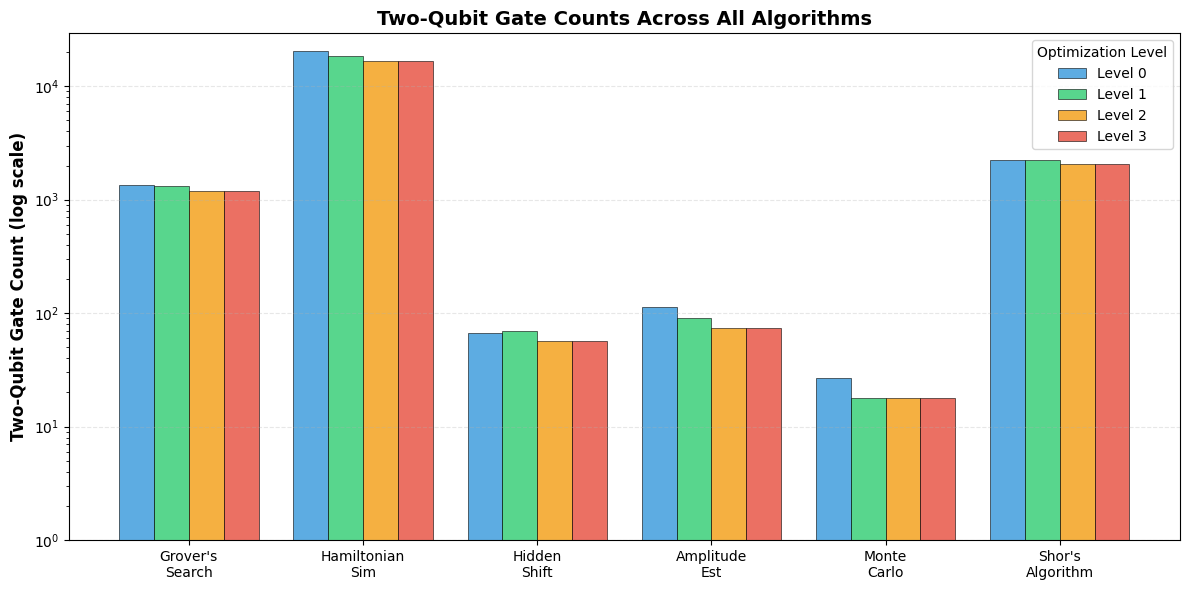


📊 Two-Qubit Gate Count Summary:
Grover's Search     : L0=1340, L1=1322, L2=1188, L3=1188
Hamiltonian Sim     : L0=20563, L1=18611, L2=16606, L3=16606
Hidden Shift        : L0=  67, L1=  70, L2=  57, L3=  57
Amplitude Est       : L0= 114, L1=  90, L2=  74, L3=  74
Monte Carlo         : L0=  27, L1=  18, L2=  18, L3=  18
Shor's Algorithm    : L0=2256, L1=2247, L2=2078, L3=2076


In [146]:
# Two-qubit gate counts visualization
fig, ax = plt.subplots(figsize=(12, 6))

labels = list(results.keys())
x = np.arange(len(labels))
width = 0.2

colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
for i, level in enumerate([0, 1, 2, 3]):
    counts = [results[algo]['two_qubit_count'][level] for algo in labels]
    offset = width * (i - 1.5)
    ax.bar(x + offset, counts, width, label=f'Level {level}', 
           color=colors[i], alpha=0.8, edgecolor='black', linewidth=0.5)

ax.set_ylabel('Two-Qubit Gate Count (log scale)', fontsize=12, fontweight='bold')
ax.set_title('Two-Qubit Gate Counts Across All Algorithms', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([l.replace(' ', '\n') for l in labels])
ax.legend(title='Optimization Level')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Use logarithmic scale to show algorithms with vastly different gate counts
ax.set_yscale('log')
ax.set_ylim(bottom=1)  # Start from 1 to avoid log(0)

plt.tight_layout()
plt.show()

print("\n📊 Two-Qubit Gate Count Summary:")
print("="*60)
for algo in labels:
    print(f"{algo:20s}: L0={results[algo]['two_qubit_count'][0]:4d}, "
          f"L1={results[algo]['two_qubit_count'][1]:4d}, "
          f"L2={results[algo]['two_qubit_count'][2]:4d}, "
          f"L3={results[algo]['two_qubit_count'][3]:4d}")

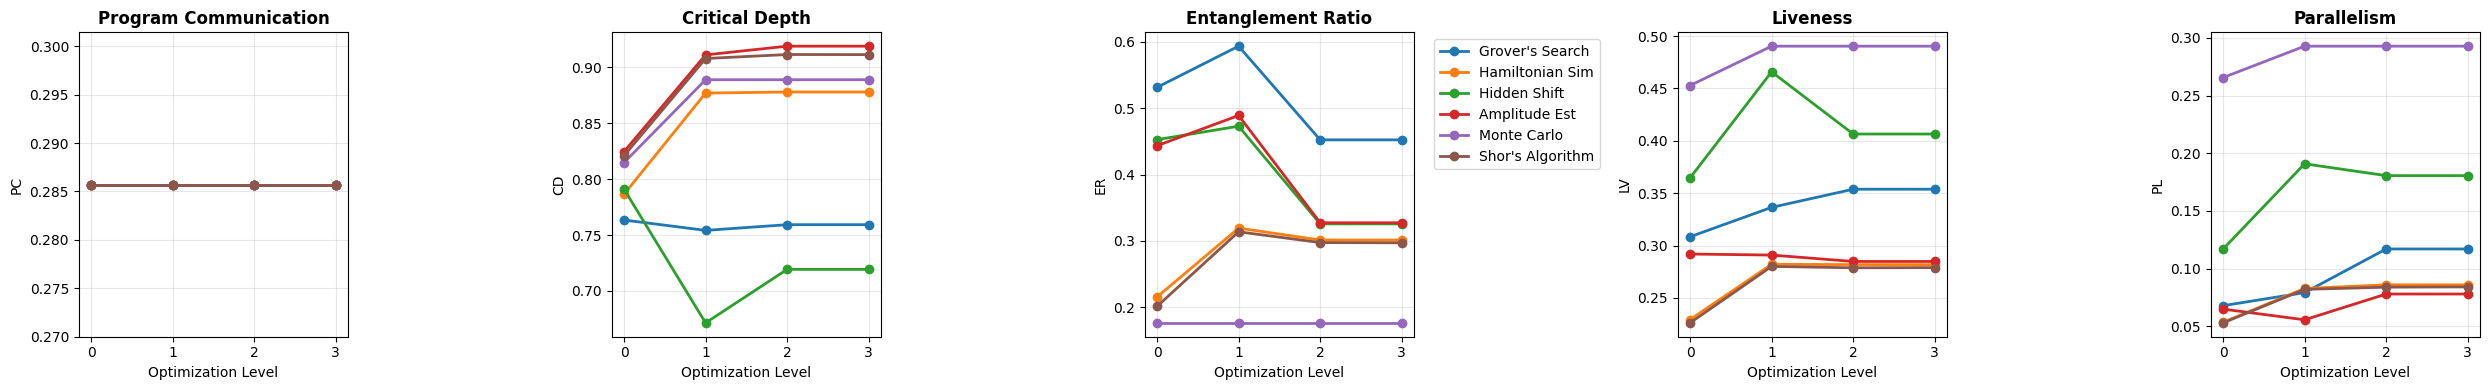

In [147]:
# SupermarQ metrics visualization
metrics_to_plot = ['PC', 'CD', 'ER', 'LV', 'PL']
metric_names = ['Program Communication', 'Critical Depth', 'Entanglement Ratio', 'Liveness', 'Parallelism']

fig, axes = plt.subplots(1, 5, figsize=(25, 4))

for idx, (metric, name) in enumerate(zip(metrics_to_plot, metric_names)):
    ax = axes[idx]
    
    for algo in results.keys():
        levels = sorted(results[algo][metric].keys())
        values = [results[algo][metric][l] for l in levels]
        ax.plot(levels, values, marker='o', label=algo, linewidth=2)
    
    ax.set_title(name, fontweight='bold')
    ax.set_xlabel('Optimization Level')
    ax.set_ylabel(metric)
    ax.set_xticks([0, 1, 2, 3])
    ax.grid(True, alpha=0.3)
    if idx == 2:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

---
## Section 7: Analysis and Interpretation

### Key Observations

1. **Optimization Trade-offs**:
   - Higher optimization levels generally reduce gate counts
   - But may increase transpilation time
   - Not always beneficial for all algorithms

2. **Algorithm Characteristics**:
   - Some algorithms (e.g., Grover) benefit more from optimization
   - Others (e.g., Hamiltonian Simulation) show minimal improvement

3. **Hardware Constraints**:
   - Qubit connectivity significantly impacts SWAP overhead
   - Two-qubit gates are the primary source of errors

### Best Practices

1. Always profile your specific algorithm on target hardware
2. Consider both gate count and circuit depth
3. Higher optimization ≠ always better
4. Use SupermarQ metrics for comprehensive evaluation

---
## Section 8: Extension Ideas & Challenges

### 🚀 Challenge 1: New Algorithm
Implement the Quantum Fourier Transform (QFT) and analyze its transpilation characteristics.

### 🚀 Challenge 2: Custom Backend
Try using a different fake backend (e.g., `Fake27QPulseV1`) and compare results.

### 🚀 Challenge 3: Error Mitigation
Research and implement basic error mitigation techniques (e.g., dynamical decoupling).

### 🚀 Challenge 4: Parameter Sweep
Vary algorithm parameters (e.g., Grover iterations) and study the impact on metrics.

### 🚀 Challenge 5: Real Hardware
If you have IBM Quantum access, run these experiments on real hardware!

In [125]:
# Workspace for your extensions and challenges

# Your code here...

---
## Conclusion

Congratulations! You've completed the Quantum Transpilation Analysis tutorial. You now understand:

✅ How quantum transpilation optimizes circuits for real hardware  
✅ The trade-offs between different optimization levels  
✅ How to use SupermarQ metrics for circuit evaluation  
✅ How to implement and analyze quantum algorithms systematically  

### Next Steps

1. **Explore** the main.py script for production-ready code
2. **Experiment** with your own quantum algorithms
3. **Read** the referenced papers for deeper theoretical understanding
4. **Contribute** improvements back to the repository

### Resources

- [Qiskit Documentation](https://qiskit.org/documentation/)
- [SupermarQ Paper](https://arxiv.org/abs/2202.11045)
- [Quantum Algorithm Zoo](https://quantumalgorithmzoo.org/)
- [IBM Quantum Experience](https://quantum-computing.ibm.com/)

---

**Happy Quantum Computing! 🎉🔬⚛️**